In [ ]:
!pip install pyspark networkx matplotlib

from pyspark.sql import SparkSession
import networkx as nx
import matplotlib.pyplot as plt
from pyspark.sql.functions import *
from itertools import combinations
from collections import defaultdict
import time
import ast

# Initialize Spark session
spark = SparkSession.builder.appName("SpotifyAnalysis").getOrCreate()

# Load and clean data
df = spark.read.csv("/content/spotify_users.csv", header=True, inferSchema=True, escape='"')

# Handle missing values
print("\n Missing Values:")
df.select([sum(col(c).isNull().cast("int")).alias(c) for c in df.columns]).show()



 Missing Values:
+----------+----+---------+----------+------+----------+
|spotify_id|name|followers|popularity|genres|chart_hits|
+----------+----+---------+----------+------+----------+
|         0|   0|        4|         0|     0|    136781|
+----------+----+---------+----------+------+----------+



In [ ]:
# CORRECT GENRE PARSING
def parse_genres(x):
    try:
        if isinstance(x, str):
            # Clean string representation
            cleaned = x.replace("'", '"').strip("[]")
            return [g.strip('"') for g in cleaned.split(', ') if g]
        return list(x) if isinstance(x, (list, set)) else []
    except:
        return []


pandas_df = df.toPandas()
pandas_df['genres'] = pandas_df['genres'].apply(parse_genres)

# VERIFICATION
print("\nSample Genres:")
print(pandas_df['genres'].head(3))

# REBUILD GENRE MAPPING
genre_to_users = defaultdict(set)
for _, row in pandas_df.iterrows():
    for genre in row['genres']:
        if genre:  # Skip empty strings
            genre_to_users[genre].add(row['spotify_id'])

print(f"\nUnique Genres: {len(genre_to_users)}")
print("Sample Genres:", list(genre_to_users.keys())[:5])


Sample Genres:
0            [nordic house, russelater]
1    [christlicher rap, german hip hop]
2                                    []
Name: genres, dtype: object

Unique Genres: 4853
Sample Genres: ['nordic house', 'russelater', 'christlicher rap', 'german hip hop', 'dancehall']


In [ ]:
import time
start = time.time()


# Step 3: Create Graph and add nodes
import networkx as nx
G = nx.Graph()
for _, row in pandas_df.iterrows():
    G.add_node(row['spotify_id'],
               name=row['name'],
               followers=row['followers'],
               popularity=row['popularity'],
               genres=row['genres'])

# Step 4: Add edges between users sharing at least one genre
edge_set = set()
for users in genre_to_users.values():
    for u, v in combinations(users, 2):
        # To avoid duplicate edges
        if (u, v) not in edge_set and (v, u) not in edge_set:
            G.add_edge(u, v)
            edge_set.add((u, v))

end = time.time()
print(f"Graph built in {end - start:.2f} seconds")


Graph built in 24.69 seconds


In [ ]:
print(f"\n Dataset Overview:")
print(f"Nodes (Artists): {G.number_of_nodes()}")
print(f"Edges (Genre-based Connections): {G.number_of_edges()}")



 Dataset Overview:
Nodes (Artists): 156320
Edges (Genre-based Connections): 4953165


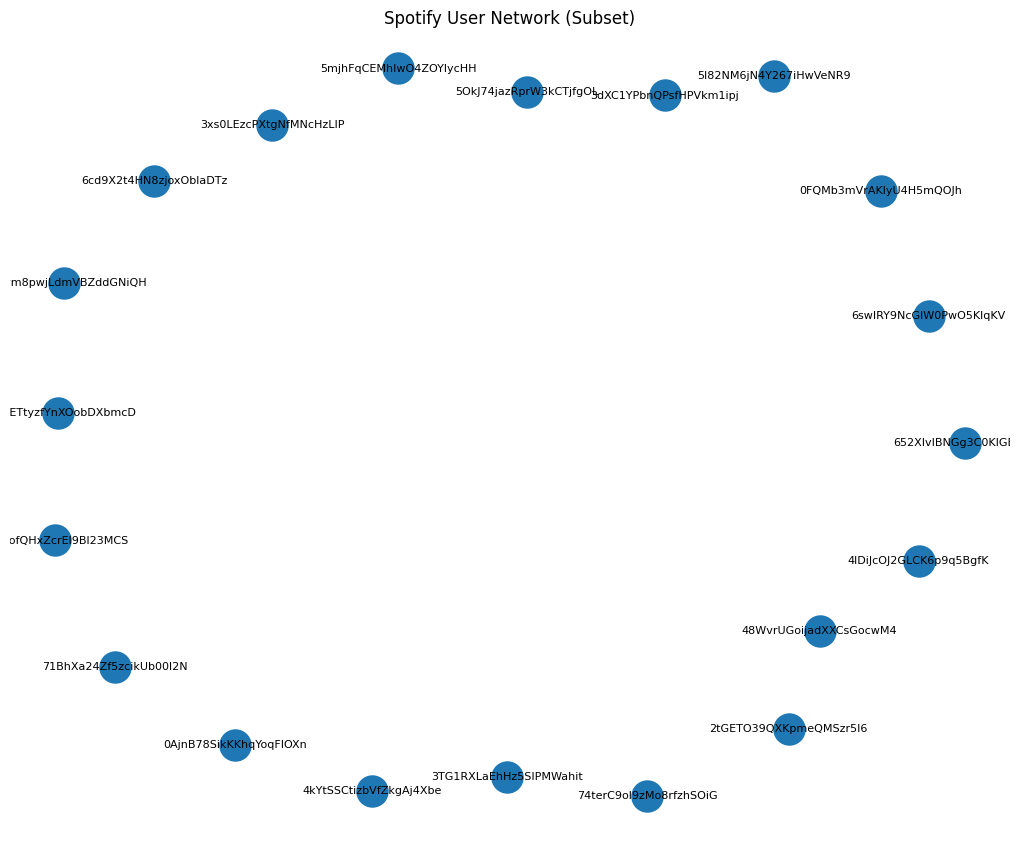

In [ ]:
import matplotlib.pyplot as plt

# Create subgraph with first 20 nodes
sub_G = G.subgraph(list(G.nodes())[:20])
plt.figure(figsize=(10, 8))
nx.draw(sub_G, with_labels=True, node_size=500, font_size=8)
plt.title("Spotify User Network (Subset)")
plt.show()


In [ ]:
import networkx as nx
import time
import random

def fast_closeness_centrality(G, sample_size=100, seed=42):
    """Approximate closeness centrality using node sampling."""
    random.seed(seed)
    nodes = list(G.nodes())
    sampled_nodes = random.sample(nodes, min(sample_size, len(nodes)))
    closeness = {}

    for node in sampled_nodes:
        try:
            closeness[node] = nx.closeness_centrality(G, u=node)
        except:
            closeness[node] = 0
    return closeness

def fast_betweenness_centrality(G, sample_size=50, seed=42):
    """Approximate betweenness centrality using sampling."""
    return nx.betweenness_centrality(G, k=sample_size, seed=seed)

def compute_and_attach_centralities(G, pandas_df, fast_mode=True, sample_size=50, verbose=True):
    """
    Computes centrality measures and attaches them to the DataFrame.
    Set fast_mode=False to compute exact values (slow!).
    """
    centralities = {}

    # Centrality functions (fast vs full)
    if fast_mode:
        centrality_functions = {
            'degree': nx.degree_centrality,
            'betweenness': lambda G: fast_betweenness_centrality(G, sample_size),
            'closeness': lambda G: fast_closeness_centrality(G, sample_size),
            'eigenvector': lambda G: nx.eigenvector_centrality(G, max_iter=1000),
            'pagerank': nx.pagerank,
        }
    else:
        centrality_functions = {
            'degree': nx.degree_centrality,
            'betweenness': nx.betweenness_centrality,
            'closeness': nx.closeness_centrality,
            'eigenvector': lambda G: nx.eigenvector_centrality(G, max_iter=1000),
            'pagerank': nx.pagerank,
        }

    # Compute all centralities
    for name, func in centrality_functions.items():
        if verbose: print(f" {name.capitalize()} Centrality...")
        start = time.time()
        try:
            centralities[name] = func(G)
        except nx.PowerIterationFailedConvergence:
            if verbose: print(f" {name.capitalize()} failed to converge. Filling with 0s.")
            centralities[name] = {node: 0 for node in G.nodes()}
        if verbose: print(f" {name.capitalize()} done in {time.time() - start:.2f}s")

    # Attach to DataFrame
    centrality_df = pandas_df.copy()
    for measure in centralities:
        centrality_df[measure] = centrality_df['spotify_id'].map(centralities[measure]).fillna(0)

    #  Disclaimer
    if fast_mode:
        print("\n Note: Closeness & Betweenness centralities are approximated using sampling.")
        print(f"   Set `fast_mode=False` to compute exact (but slow) values.\n")

    return centrality_df, centralities

# Compute centralities
min = __builtins__.min
centrality_df, centralities = compute_and_attach_centralities(G, pandas_df, verbose=True)


🔍 Degree Centrality...
✅ Degree done in 0.22s
🔍 Betweenness Centrality...
✅ Betweenness done in 113.28s
🔍 Closeness Centrality...
✅ Closeness done in 12.26s
🔍 Eigenvector Centrality...
✅ Eigenvector done in 81.45s
🔍 Pagerank Centrality...
✅ Pagerank done in 35.53s

 Note: Closeness & Betweenness centralities are approximated using sampling.
   Set `fast_mode=False` to compute exact (but slow) values.



In [ ]:
def get_top_artists(centrality_df, measure):
    return (centrality_df.sort_values(measure, ascending=False)
            [['name', measure]].head(5)
            .reset_index(drop=True))
for measure in centralities:
    centrality_df[measure] = centrality_df['spotify_id'].map(centralities[measure])

print("\n Top Influential Artists:")
for measure in centralities:
    print(f"\n {measure.upper()} TOP 5:")
    display(get_top_artists(centrality_df, measure))


🏆 Top Influential Artists:

⭐ DEGREE TOP 5:


,name,degree
0,Matoma,0.014969
1,Zedd,0.014867
2,Seeb,0.014080
3,Loote,0.014055
4,Martin Jensen,0.013581



⭐ BETWEENNESS TOP 5:


,name,betweenness
0,DJ Assad,0.006802
1,Menor Menor,0.006762
2,Joe Vasconcellos,0.006757
3,Mikko Alatalo,0.004861
4,Pabllo Vittar,0.003943



⭐ CLOSENESS TOP 5:


,name,closeness
0,Yomo,0.096919
1,Papatinho,0.091803
2,Maj Monet,0.091512
3,&ME,0.090470
4,Kimberose,0.083772



⭐ EIGENVECTOR TOP 5:


,name,eigenvector
0,Zedd,0.049949
1,Matoma,0.047074
2,Rita Ora,0.046271
3,Jax Jones,0.045867
4,Martin Jensen,0.045501



⭐ PAGERANK TOP 5:


,name,pagerank
0,Yves V,0.000059
1,Loote,0.000056
2,Matoma,0.000056
3,Allie X,0.000056
4,Fedde Le Grand,0.000055


In [ ]:
# Step 5: Average Degree of the Graph
degrees = dict(G.degree())
avg_degree = __builtins__.sum(degrees.values()) / len(G.nodes())
print(f"\n Average Degree of the Graph: {avg_degree:.2f}")

# Step 6: Graph Properties
components = list(nx.connected_components(G))
num_components = len(components)
largest_component = __builtins__.max(components, key=len)
largest_component_size = len(largest_component)

print(f"\n Number of Connected Components: {num_components}")
print(f" Size of Largest Component: {largest_component_size}")




📈 Average Degree of the Graph: 63.37

🧩 Number of Connected Components: 102672
🔗 Size of Largest Component: 53122


In [ ]:
import time
import builtins
from networkx.algorithms import approximation

def compute_graph_diameter(G_largest, use_fast=True, verbose=True):
    if verbose:
        print(f"\n📏 Computing Diameter of Largest Component ({'Fast' if use_fast else 'Exact'} Mode)...")
    start = time.time()

    try:
        if use_fast:
            diameter = approximation.diameter(G_largest)
        else:
            diameter = nx.diameter(G_largest)
        if verbose:
            print(f" Diameter: {diameter} (computed in {time.time() - start:.2f}s)")
    except nx.NetworkXError:
        print(" Could not compute diameter. The graph might be disconnected.")
        diameter = None
    return diameter

#  Safe use of max in PySpark context
largest_component = builtins.max(nx.connected_components(G), key=len)
G_largest = G.subgraph(largest_component).copy()

#  Fast mode recommended
_ = compute_graph_diameter(G_largest, use_fast=True)

#  Uncomment below for exact (slow) mode
# _ = compute_graph_diameter(G_largest, use_fast=False)



📏 Computing Diameter of Largest Component (Fast Mode)...
✅ Diameter: 13 (computed in 1.66s)


In [ ]:

from pyspark.ml import Pipeline
from pyspark.ml.feature import VectorAssembler, StandardScaler
from pyspark.ml.regression import LinearRegression
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml.linalg import DenseVector

full_df = spark.createDataFrame(centrality_df)

# Keep only relevant columns and handle missing values
numeric_cols = ['followers', 'degree', 'betweenness',
                'closeness', 'eigenvector', 'pagerank',
                'popularity']
clean_df = full_df.select(numeric_cols).na.drop()

print(f"\n Final Dataset Size: {clean_df.count()} rows")

# 2. Feature Engineering Pipeline
# -------------------------------
assembler = VectorAssembler(
    inputCols=numeric_cols[:-1],
    outputCol="raw_features"
)

scaler = StandardScaler(
    inputCol="raw_features",
    outputCol="features",
    withStd=True,
    withMean=True
)

pipeline = Pipeline(stages=[assembler, scaler])
processed_data = pipeline.fit(clean_df).transform(clean_df)

# 3. Data Splitting
# -----------------
train, test = processed_data.randomSplit([0.8, 0.2], seed=42)
print(f"\n Training Set: {train.count()} ({(train.count()/clean_df.count())*100:.1f}%)")
print(f" Test Set: {test.count()} ({(test.count()/clean_df.count())*100:.1f}%)")

# 4. Model Training with Regularization
# -------------------------------------
lr = LinearRegression(
    featuresCol="features",
    labelCol="popularity",
    elasticNetParam=0.5,  # Balance L1/L2 regularization
    maxIter=100
)

# 5. Cross-Validation
# -------------------
param_grid = (ParamGridBuilder()
              .addGrid(lr.regParam, [0.01, 0.1, 1.0])
              .build())

evaluator = RegressionEvaluator(
    labelCol="popularity",
    predictionCol="prediction",
    metricName="r2"
)

cv = CrossValidator(
    estimator=lr,
    estimatorParamMaps=param_grid,
    evaluator=evaluator,
    numFolds=3,
    parallelism=4
)

cv_model = cv.fit(train)

# 6. Best Model Evaluation
# ------------------------
best_model = cv_model.bestModel
predictions = best_model.transform(test)

print("\n🔧 Best Model Parameters:")
print(f"Regularization Param: {best_model._java_obj.getRegParam()}")
print(f"Elastic Net Param: {best_model._java_obj.getElasticNetParam()}")

# 7. Performance Metrics
# ----------------------
rmse = evaluator.evaluate(predictions, {evaluator.metricName: "rmse"})
r2 = evaluator.evaluate(predictions, {evaluator.metricName: "r2"})

print(f"\n RMSE: {rmse:.2f}")
print(f" R²: {r2:.4f}")



📊 Final Dataset Size: 50 rows

📚 Training Set: 38 (76.0%)
🧪 Test Set: 12 (24.0%)

🔧 Best Model Parameters:
Regularization Param: 1.0
Elastic Net Param: 0.5

📉 RMSE: 12.15
📈 R²: 0.4312


In [ ]:
from pyspark.ml.linalg import DenseVector
# Reset built-ins
import builtins
abs = builtins.abs
float = builtins.float
sorted = builtins.sorted

# Extract coefficients and intercept
coefficients = best_model.coefficients
if isinstance(coefficients, DenseVector):
    coefficients = coefficients.toArray()

feature_names = numeric_cols[:-1]
intercept = best_model.intercept

# Pair with feature names and sort
importance = sorted(zip(feature_names, coefficients),
                    key=lambda x: abs(x[1]),
                    reverse=True)

print("\nFeature Importance:")
for name, weight in importance:
    print(f"{name:<15}: {weight:.4f}")
print(f"\nIntercept: {intercept:.4f}")



Feature Importance:
closeness      : 5.4182
followers      : 4.0516
betweenness    : 3.0429
pagerank       : 2.8439
degree         : 0.0000
eigenvector    : 0.0000

Intercept: 20.4959


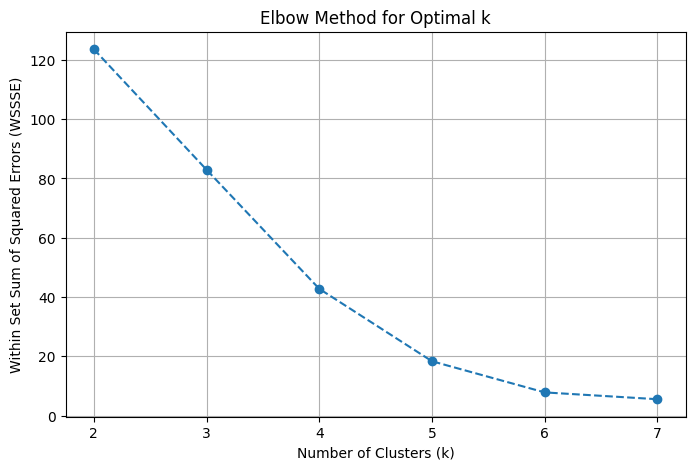


📐 Silhouette Score (k=3): 0.8502

📊 Cluster Characteristics:

🔹 Cluster 0:
  - Avg Followers: -0.0629
  - Avg Degree: 0.2680
  - Avg Betweenness: -0.1341
  - Avg Closeness: 1.7768
  - Avg Eigenvector: 3.6757
  - Avg Pagerank: 0.9186

🔹 Cluster 1:
  - Avg Followers: -0.2445
  - Avg Degree: -0.2660
  - Avg Betweenness: -0.2008
  - Avg Closeness: -0.1953
  - Avg Eigenvector: -0.2824
  - Avg Pagerank: -0.2436

🔹 Cluster 2:
  - Avg Followers: 3.7094
  - Avg Degree: 3.8120
  - Avg Betweenness: 3.1017
  - Avg Closeness: 1.7445
  - Avg Eigenvector: 1.7855
  - Avg Pagerank: 3.0418


In [ ]:
from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator
import matplotlib.pyplot as plt

# --------------------  Step 1: Prepare Clustering Data --------------------
# Reuse the same processed data and select only features (no labels)
clustering_data = processed_data.select("features")

# --------------------  Step 2: Elbow Method --------------------
costs = []
k_range = range(2, 8)

for k in k_range:
    kmeans = KMeans(featuresCol='features', k=k, seed=42)
    model = kmeans.fit(clustering_data)
    costs.append(model.summary.trainingCost)

# Plot the Elbow Curve
plt.figure(figsize=(8, 5))
plt.plot(k_range, costs, marker='o', linestyle='--')
plt.title("Elbow Method for Optimal k")
plt.xlabel("Number of Clusters (k)")
plt.ylabel("Within Set Sum of Squared Errors (WSSSE)")
plt.grid(True)
plt.show()

# -------------------- Step 3: Fit Final KMeans --------------------
optimal_k = 3  # Change if elbow shows better k
kmeans = KMeans(featuresCol='features', k=optimal_k, seed=42)
model = kmeans.fit(clustering_data)
predictions = model.transform(clustering_data)

# --------------------  Step 4: Evaluate Clustering --------------------
evaluator = ClusteringEvaluator(featuresCol='features', predictionCol='prediction')
silhouette = evaluator.evaluate(predictions)
print(f"\n Silhouette Score (k={optimal_k}): {silhouette:.4f}")

# --------------------  Step 5: Print Cluster Centers --------------------
centers = model.clusterCenters()
feature_names = numeric_cols[:-1]  # ['followers', 'degree', ..., 'pagerank']

print("\n Cluster Characteristics:")
for i, center in enumerate(centers):
    print(f"\n Cluster {i}:")
    for j, val in enumerate(center):
        print(f"  - Avg {feature_names[j].capitalize()}: {val:.4f}")
